In [1]:
import pandas as pd
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE


        Status Application Creation Date Approved / Refused Date  \
4920  Recorded                09/04/2009              14/08/2009   
670   Recorded                23/04/2009              09/06/2009   
8771  Recorded                23/04/2009              13/05/2009   
5222  Recorded                23/04/2009              13/05/2009   
4134  Recorded                05/05/2009              27/05/2009   
...        ...                       ...                     ...   
2514  Recorded                02/04/2024              11/04/2024   
3385  Recorded                04/04/2024              11/04/2024   
5773  Recorded                11/04/2024              16/04/2024   
6748  Recorded                11/04/2024              12/04/2024   
3356  Recorded                12/04/2024              16/04/2024   

     Recorded / Rejected Date Water Share ID Water System Source Reliability  \
4920               12/10/2009      WEE****70            Goulburn        High   
670                03/0

In [ ]:

# Load the data from CSV files into DataFrames
zone_data_1A = pd.read_csv('zone_data_1A_clustered.csv', nrows=40000)
zone_data_7 = pd.read_csv('zone_data_7_clustered.csv')
zone_data_6 = pd.read_csv('zone_data_6_clustered.csv')

# Separate zone_data_1A into two different DataFrames based on the cluster assignment
zone_data_1A_top = zone_data_1A[zone_data_1A['Cluster'] == 0]
zone_data_1A_bottom = zone_data_1A[zone_data_1A['Cluster'] == 1]

zone_data_7_top = zone_data_7[zone_data_7['Cluster'] == 0]
zone_data_7 = zone_data_7[zone_data_7['Cluster'] == 1]

zone_data_6_top = zone_data_6[zone_data_6['Cluster'] == 1]
zone_data_6 = zone_data_6[zone_data_6['Cluster'] == 0]

# Copy the data to avoid SettingWithCopyWarning
zone_data_1A_top_sorted = zone_data_1A_top.copy()
zone_data_1A_bottom_sorted = zone_data_1A_bottom.copy()

# Copy the data for zone 6 and zone 7 to avoid SettingWithCopyWarning
zone_data_6_top_sorted = zone_data_6_top.copy()
zone_data_6_bottom_sorted = zone_data_6.copy()

zone_data_7_top_sorted = zone_data_7_top.copy()
zone_data_7_bottom_sorted = zone_data_7.copy()

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_1A_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_1A_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_6_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_6_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zone_data_7_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_7_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

print(zone_data_1A_top_sorted)




# ARIMAX

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


WATERTEMP = pd.read_csv('../GET_WATER_DATA_ONLINE/DailyMeanTempData.csv', parse_dates=['Time'], index_col='Time')
#TURBIDITY = pd.read_csv(Turbidity_temp_file_path, parse_dates=['Time'], index_col='Time')
#AIRTEMP = pd.read_csv(DryAir_temp_file_path, parse_dates=['Time'], index_col='Time')
RAINFALL = pd.read_csv('../GET_WATER_DATA_ONLINE/DailyMeanRainfall.csv', parse_dates=['Time'], index_col='Time')
WATERCOURSE = pd.read_csv('../GET_WATER_DATA_ONLINE/DailyMeanWaterCourseDischarge.csv', parse_dates=['Time'], index_col='Time')
#ELECTRICALCOND = pd.read_csv(EC_temp_file_path, parse_dates=['Time'], index_col='Time')


ZONEDATA = zone_data_7_top_sorted


from statsmodels.tsa.stattools import adfuller

# Function to test stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Assuming 'principal component 1' as the target series
test_stationarity(ZONEDATA['principal component 1'])


In [3]:
# Combine exogenous data into a single DataFrame, aligning by date
# Exclude turbidity and aritemp, electric conductivity due to not enough data
exog_data = pd.concat(
    [WATERTEMP, 
     #TURBIDITY, 
     #AIRTEMP, 
     RAINFALL, 
     WATERCOURSE, 
     #ELECTRICALCOND
     ], axis=1)

# Assuming 'finalDf' and 'principal component 1' are already defined and correct
# Make sure 'finalDf' is also indexed by date

# Aligning exogenous data with finalDf
exog_data.index = pd.to_datetime(exog_data.index)

exog_data = exog_data.fillna(method='bfill').interpolate(method='time')
print(exog_data.shape)



exog_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace all inf/-inf with NaN
exog_data = exog_data.dropna(axis=1)
exog_data = exog_data.dropna(axis=0)
print(exog_data.shape)
print(exog_data)


C:\Users\Meredith\AppData\Local\Temp\ipykernel_18520\561919590.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_data = exog_data.fillna(method='bfill').interpolate(method='time')


(14000, 2487)
(14000, 2487)
                           2122518  2122711  2122713  2122725   215208  \
Time                                                                     
2010-01-01 00:00:00+10:00    21.14    22.95    20.19    22.99    17.86   
2010-01-01 00:30:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-01 02:00:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-02 00:00:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-02 00:30:00+10:00    21.14    22.54    20.19    19.27    17.86   
...                            ...      ...      ...      ...      ...   
2023-12-30 00:00:00+10:00     0.00    20.64    19.25    18.84 -9999.00   
2023-12-30 00:30:00+10:00     0.00    20.67    19.25    18.84 -9999.00   
2023-12-31 00:00:00+10:00     0.00    20.67    19.25    18.84 -9999.00   
2023-12-31 00:30:00+10:00     0.00    20.53    19.25    18.84 -9999.00   
2024-01-01 00:00:00+10:00     0.00    20.53    19.25    18.84 -9999.00   

         

In [4]:
# Create final DataFrame
finalDf = ZONEDATA.copy()
# Assuming 'Create_date' is the column to align by
finalDf['Create_date'] = pd.to_datetime(finalDf['Create_date'])
finalDf.set_index('Create_date', inplace=True)

# Convert index to datetime if it isn't already
exog_data.index = pd.to_datetime(exog_data.index)
# Remove time zone information from exog_data
exog_data.index = exog_data.index.tz_localize(None)

# Resample to daily frequency using the mean
exog_data_daily = exog_data.resample('D').mean()

print(exog_data_daily)


            2122518    2122711  2122713    2122725   215208       215209  \
Time                                                                       
2010-01-01    21.14  23.170000    20.19  23.130000    17.86    24.540000   
2010-01-02    21.14  22.786667    20.19  20.580000    17.86    23.513333   
2010-01-03    21.14  22.173333    20.19  20.576667    17.86    22.746667   
2010-01-04    21.14  22.570000    20.19  21.663333    17.86    23.153333   
2010-01-05    21.14  23.326667    20.19  22.293333    17.86    23.836667   
...             ...        ...      ...        ...      ...          ...   
2023-12-28     0.00  19.585000    19.25  18.840000 -9999.00 -7999.000000   
2023-12-29     0.00  20.250000    19.25  18.840000 -9999.00 -7999.000000   
2023-12-30     0.00  20.655000    19.25  18.840000 -9999.00 -7999.000000   
2023-12-31     0.00  20.600000    19.25  18.840000 -9999.00 -7999.000000   
2024-01-01     0.00  20.530000    19.25  18.840000 -9999.00 -7999.000000   

           

            Principal Component 1  Principal Component 2  \
Time                                                       
2010-01-01               0.559262              26.909626   
2010-01-02             -10.349802              13.928652   
2010-01-03             -16.981906               8.601545   
2010-01-04             -18.237293               9.168417   
2010-01-05             -18.939854               9.491767   
...                           ...                    ...   
2023-12-28              -3.541601               8.144014   
2023-12-29              -7.541435               8.566159   
2023-12-30              -9.789410               8.326155   
2023-12-31             -12.261539               8.728653   
2024-01-01             -13.093952               9.693901   

            Principal Component 3  Principal Component 4  \
Time                                                       
2010-01-01              -0.263770              23.269233   
2010-01-02               6.392663      

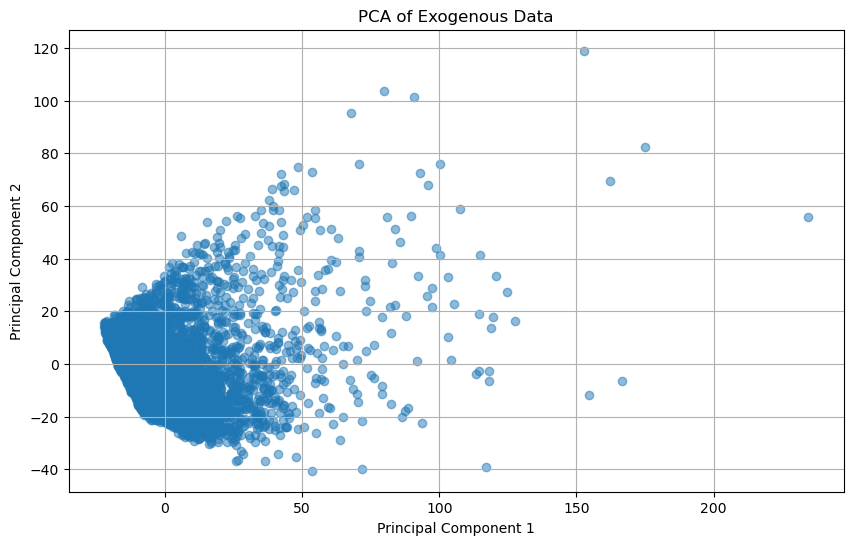

Principal Component 1: 15.92%
Principal Component 2: 9.37%
Principal Component 3: 6.72%
Principal Component 4: 5.42%
Principal Component 5: 3.70%
Principal Component 6: 2.89%
Principal Component 7: 2.40%
Principal Component 8: 1.96%
Principal Component 9: 1.74%
Principal Component 10: 1.69%
sum:  0.5181390962225157


In [5]:
# Standardize the data
scaler = StandardScaler()
exog_data_standardized = scaler.fit_transform(exog_data_daily)


# Number of principal components to keep
n_components = 10  # Adjust this number as needed

# Fit PCA model
pca = PCA(n_components)  # Number of components can be adjusted
principalComponents = pca.fit_transform(exog_data_standardized)

principal_component_labels = [f'Principal Component {i+1}' for i in range(n_components)]
combined_principal_df = pd.DataFrame(data=principalComponents, columns=principal_component_labels, index=exog_data_daily.index)
print(combined_principal_df)

plt.figure(figsize=(10, 6))
plt.scatter(combined_principal_df['Principal Component 1'], combined_principal_df['Principal Component 2'], alpha=0.5)
plt.title('PCA of Exogenous Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Display explained variance
explained_variance = pca.explained_variance_ratio_
for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {variance * 100:.2f}%")
print("sum: ", sum(explained_variance))



In [6]:

# Combine the PCA DataFrame with alignedDf['Price Per ML ($)']
NEW_PCA_COMBINED_DF = combined_principal_df.join(finalDf['Price Per ML ($)'], how='inner')
print(NEW_PCA_COMBINED_DF)



            Principal Component 1  Principal Component 2  \
2010-01-04             -18.237293               9.168417   
2010-01-04             -18.237293               9.168417   
2010-01-04             -18.237293               9.168417   
2010-01-05             -18.939854               9.491767   
2010-01-05             -18.939854               9.491767   
...                           ...                    ...   
2023-12-21             -13.311171               8.836721   
2023-12-21             -13.311171               8.836721   
2023-12-22             -13.179996              10.723847   
2023-12-22             -13.179996              10.723847   
2023-12-22             -13.179996              10.723847   

            Principal Component 3  Principal Component 4  \
2010-01-04               7.795492              15.517743   
2010-01-04               7.795492              15.517743   
2010-01-04               7.795492              15.517743   
2010-01-05               7.972846      

In [7]:

# Assuming 'Create_date' is the column to align by and it is already the index
finalDf.index = pd.to_datetime(finalDf.index)

# Ensure it's tz-naive
finalDf.index = finalDf.index.tz_localize(None)

# Join the datasets
alignedDf = finalDf.join(exog_data_daily, how='inner')  # 'inner' to keep only matched indices



# Check for any remaining NaN values and drop if necessary
alignedDf.dropna(axis=1, inplace=True)




columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal']

alignedDf = alignedDf.drop(columns=columns_to_exclude, errors='ignore')  # errors='ignore' to handle any missing columns gracefully

print(alignedDf)



            Volume Traded (ML)  Price Per ML ($)  2122518    2122711  2122713  \
2010-01-04               314.0           2377.46    21.14  22.570000   20.190   
2010-01-04              4400.0           1800.00    21.14  22.570000   20.190   
2010-01-04                20.0           2300.00    21.14  22.570000   20.190   
2010-01-05                80.0           2375.00    21.14  23.326667   20.190   
2010-01-05                50.0           2400.00    21.14  23.326667   20.190   
...                        ...               ...      ...        ...      ...   
2023-12-21                 2.0           7500.00     0.00  20.475000   18.935   
2023-12-21                 3.0           6650.00     0.00  20.475000   18.935   
2023-12-22                 2.0           7500.00     0.00  20.345000   18.655   
2023-12-22                 1.7           7500.00     0.00  20.345000   18.655   
2023-12-22                 2.2           7250.00     0.00  20.345000   18.655   

              2122725   215

# Sarimax with correct plotting time and splitting into test/train

## Is there seasonality? Lets check

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

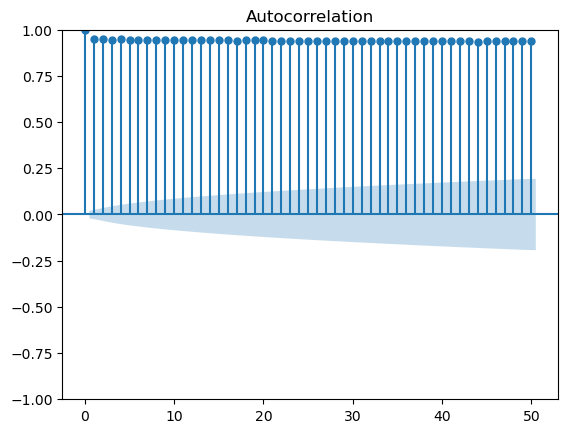

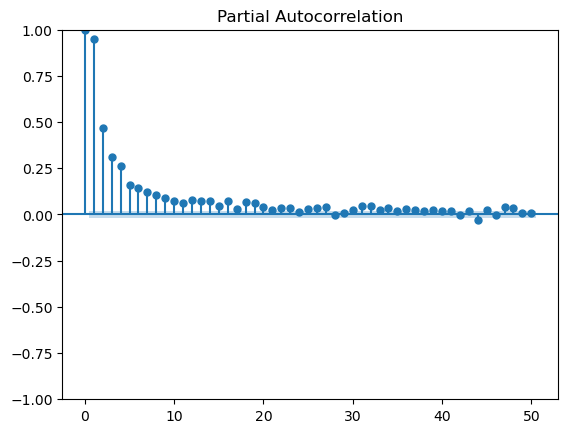

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(NEW_PCA_COMBINED_DF['Price Per ML ($)'], lags=50)
plot_pacf(NEW_PCA_COMBINED_DF['Price Per ML ($)'], lags=50)
plt.show()







## Plotting SARIMAX with ratio of training and test data

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


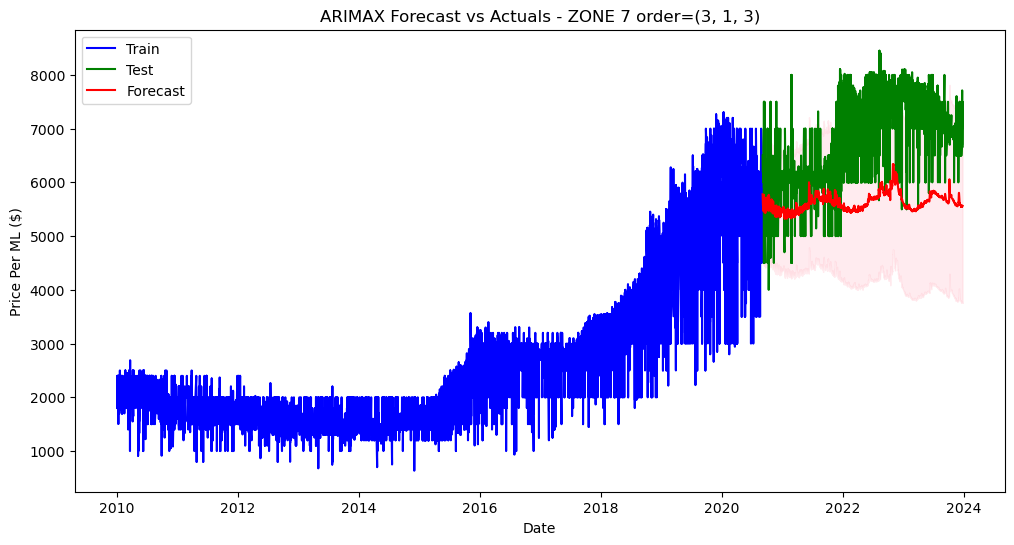

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Price Per ML ($)   No. Observations:                 7232
Model:             SARIMAX(10, 1, 10)   Log Likelihood              -55154.138
Date:                Mon, 03 Jun 2024   AIC                         110370.277
Time:                        11:07:56   BIC                         110583.747
Sample:                             0   HQIC                        110443.715
                               - 7232                                         
Covariance Type:                  opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Principal Component 1      3.7364      1.386      2.695      0.007       1.019       6.454
Principal Component 2     -3.4447      1.326     -2.598      0.009      -6.043      -0.846
Principal Component 3      1.8810      2.182      0.862      0.389      -2.395       6.157
Principal Component 4    -11.4613      8.401     -1.364      0.172     -27.926       5.004
Principal Component 5     -0.5975      1.301     -0.459      0.646      -3.147       1.952
Principal Component 6      1.6656      1.736      0.959      0.337      -1.737       5.068
Principal Component 7     -2.0148      6.017     -0.335      0.738     -13.808       9.779
Principal Component 8      1.8206      4.205      0.433      0.665      -6.422      10.063
Principal Component 9      2.8261      3.344      0.845      0.398      -3.727       9.380
Principal Component 10    -6.6114      4.431     -1.492      0.136     -15.295       2.073
ar.L1                     -0.9660      0.108     -8.939      0.000      -1.178      -0.754
ar.L2                     -0.0097      0.140     -0.069      0.945      -0.284       0.265
ar.L3                      0.1732      0.119      1.453      0.146      -0.061       0.407
ar.L4                      0.2027      0.050      4.063      0.000       0.105       0.301
ar.L5                     -0.4289      0.043     -9.917      0.000      -0.514      -0.344
ar.L6                     -0.9488      0.054    -17.439      0.000      -1.055      -0.842
ar.L7                     -0.5633      0.131     -4.301      0.000      -0.820      -0.307
ar.L8                      0.3277      0.132      2.488      0.013       0.070       0.586
ar.L9                      0.4985      0.084      5.911      0.000       0.333       0.664
ar.L10                     0.0209      0.013      1.586      0.113      -0.005       0.047
ma.L1                      0.0667      0.108      0.618      0.537      -0.145       0.278
ma.L2                     -0.8931      0.104     -8.615      0.000      -1.096      -0.690
ma.L3                     -0.2277      0.125     -1.819      0.069      -0.473       0.018
ma.L4                     -0.0369      0.105     -0.350      0.726      -0.243       0.170
ma.L5                      0.6024      0.070      8.611      0.000       0.465       0.739
ma.L6                      0.5470      0.071      7.673      0.000       0.407       0.687
ma.L7                     -0.2897      0.112     -2.593      0.010      -0.509      -0.071
ma.L8                     -0.8740      0.124     -7.053      0.000      -1.117      -0.631
ma.L9                     -0.2328      0.097     -2.405      0.016      -0.423      -0.043
ma.L10                     0.4338      0.089      4.898      0.000       0.260       0.607
sigma2                  2.528e+05   2331.381    108.440      0.000    2.48e+05    2.57e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB): 

In [9]:
# Convert back to datetime
NEW_PCA_COMBINED_DF.index = pd.to_datetime(NEW_PCA_COMBINED_DF.index)

train_size = int(len(NEW_PCA_COMBINED_DF) * 0.8)  # 80% for training
train, test = NEW_PCA_COMBINED_DF[:train_size], NEW_PCA_COMBINED_DF[train_size:]

# Separate dependent and independent variables
y_train = train['Price Per ML ($)']
X_train = train.drop(columns=['Price Per ML ($)'])
y_test = test['Price Per ML ($)']
X_test = test.drop(columns=['Price Per ML ($)'])


model = sm.tsa.statespace.SARIMAX(
    y_train,
    exog=X_train,  # Exclude target variable from exog
    order=(10, 1, 10),
    #seasonal_order=(1, 0, 1, 365)
)


results = model.fit(method='lbfgs', maxiter=1000)

# 2. Powell's Method
#results = model.fit(method='powell', maxiter=1000)



forecast_steps = len(test)  # Forecast for the length of the test set
forecast_exog = X_test.iloc[:forecast_steps][principal_component_labels]  # Ensure the same exog columns
forecast = results.get_forecast(steps=forecast_steps, exog=forecast_exog)
forecast_ci = forecast.conf_int()


# Align the forecast with the test data index
forecast_index = test.index


plt.figure(figsize=(12, 6))

# Plot observed data
plt.plot(train.index, train['Price Per ML ($)'], label='Train', color='blue')

# Plot test data
plt.plot(test.index, test['Price Per ML ($)'], label='Test', color='green')

# Plot forecasted data
plt.plot(forecast_index, forecast.predicted_mean, color='r', label='Forecast')

plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('ARIMAX Forecast vs Actuals - ZONE 7 order=(3, 1, 3)')
plt.xlabel('Date')
plt.ylabel('Price Per ML ($)')
plt.legend()
plt.show()

results.summary()


In [24]:
NEW_PCA_COMBINED_DF.groupby(pd.Grouper(freq='ME')).median().to_pickle('exo_data.pkl') # using pickle instead of csv to preserve datatypes

In [17]:
forecast_exog.groupby(pd.Grouper(freq='ME')).median()

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10
2020-09-30,-1.210628,-8.670457,-2.543335,-9.307955,1.815148,-1.691668,1.109840,0.536552,2.544952,-5.168263
2020-10-31,3.751120,-6.627149,4.157558,-9.508179,1.330201,0.521499,2.232333,-3.774138,-0.952883,-6.194376
2020-11-30,-11.208012,4.872302,7.662632,-6.929082,1.001602,1.213632,4.204800,-2.765808,0.523941,-6.265951
2020-12-31,-12.813227,10.134768,6.578395,-6.344990,2.130667,2.628918,4.569239,-3.231115,-0.138202,-6.314806
2021-01-31,-12.301229,17.246252,4.352090,-5.938638,2.702037,1.868740,5.642445,-3.324621,-1.349050,-5.659788
2021-02-28,-17.150298,8.746729,6.111470,-5.546955,1.633151,0.219312,5.202562,-3.275163,-0.770726,-5.049840
2021-03-31,-13.629906,6.320327,3.168721,-6.498864,-0.345737,-0.942090,5.317920,0.222404,0.146611,-3.598382
2021-04-30,-10.132615,-4.785976,-4.336574,-7.608761,2.346740,-2.408357,2.772637,4.109677,3.519175,-2.327109
2021-05-31,-0.943687,-5.006847,-11.158618,-10.156556,-3.241607,-3.404916,2.725817,7.649664,2.617081,-1.450608
2021-06-30,11.230417,-7.941291,-12.912237,-12.561093,-1.025653,-5.053572,-0.280522,7.106442,-0.905431,-3.137279


In [10]:




# Assume you're using 'Price Per ML ($)' as the dependent variable
model = sm.tsa.statespace.SARIMAX(
    NEW_PCA_COMBINED_DF['Price Per ML ($)'],
    exog=NEW_PCA_COMBINED_DF.drop(columns=['Price Per ML ($)']),  # Exclude target variable from exog
    order=(2, 0, 2),
    #seasonal_order=(1, 0, 1, 12)
)
results = model.fit()

# Forecasting, plotting, etc., as needed.


forecast_steps = 2000  # Forecast for 6 months (approx. 180 days)
forecast_exog = finalDf.drop(columns=['Price Per ML ($)']).iloc[-forecast_steps:][principal_component_labels]  # Ensure the same exog columns
forecast = results.get_forecast(steps=forecast_steps, exog=forecast_exog)
forecast_ci = forecast.conf_int()

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(NEW_PCA_COMBINED_DF.index, NEW_PCA_COMBINED_DF['Price Per ML ($)'], label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='r', label='Forecast')
plt.fill_between(forecast.predicted_mean.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.9)

plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Price Per ML ($)')
plt.legend()
plt.show()



c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyError: "None of [Index(['Principal Component 1', 'Principal Component 2',\n       'Principal Component 3', 'Principal Component 4',\n       'Principal Component 5', 'Principal Component 6',\n       'Principal Component 7', 'Principal Component 8',\n       'Principal Component 9', 'Principal Component 10'],\n      dtype='object')] are in the [columns]"

In [11]:
finalDf

,Status,Application Creation Date,Approved / Refused Date,Recorded / Rejected Date,Water Share ID,Water System Source,Reliability,Trading Zone Source,Seller Water Authority,Seller Trading Zone Use,Buyer Water Authority,Buyer Trading Zone Use,Volume Traded (ML),Price Per ML ($),Create_date_ordinal,Cluster
Create_date,,,,,,,,,,,,,,,,
2008-12-23,Recorded,23/12/2008,12/07/2010,23/07/2010,WEE****38,Murray,High,7 VIC Murray - Barmah to SA,Lower Murray Water,7 VIC Murray - Barmah to SA,Lower Murray Water,7 VIC Murray - Barmah to SA,94.8,2400.00,733399,0
2009-04-30,Recorded,30/04/2009,16/06/2009,20/07/2009,WEE****45,Murray,High,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,2.0,2300.00,733527,0
2009-05-12,Recorded,12/05/2009,13/05/2009,06/07/2009,WEE****38,Murray,High,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,20.0,2300.00,733539,0
2009-05-12,Recorded,12/05/2009,27/05/2009,07/07/2009,WEE****15,Murray,High,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,100.0,2672.98,733539,0
2009-05-18,Recorded,18/05/2009,05/06/2009,06/07/2009,WEE****69,Murray,High,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,175.0,2354.00,733545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21,Recorded,21/03/2024,27/03/2024,03/04/2024,WEE****88,Murray,High,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,Lower Murray Water,7 VIC Murray - Barmah to SA,9.0,6800.00,738966,0
2024-03-28,Recorded,28/03/2024,04/04/2024,17/04/2024,WEE****14,Murray,High,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,7.0,6800.00,738973,0
2024-04-02,Recorded,02/04/2024,04/04/2024,17/04/2024,WEE****17,Murray,High,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,Goulburn-Murray Water,7 VIC Murray - Barmah to SA,5.0,6700.00,738978,0


In [ ]:
print(combined_data)



                          Time  2122711  215002  215007  215014   215208  \
0    2010-01-01 00:00:00+10:00    0.458   0.000   0.064   0.001    0.000   
1    2010-01-02 00:00:00+10:00    0.394   0.002   0.089   0.000    0.000   
2    2010-01-03 00:00:00+10:00    0.466   0.001   0.157   0.000    0.034   
3    2010-01-04 00:00:00+10:00    0.665   0.001   0.114   0.000    0.050   
4    2010-01-05 00:00:00+10:00    0.624   0.032   0.093   0.004    0.041   
...                        ...      ...     ...     ...     ...      ...   
5109 2023-12-28 00:00:00+10:00   40.762  94.502   6.055   0.029  207.445   
5110 2023-12-29 00:00:00+10:00   10.628  51.224   3.747   0.026  101.668   
5111 2023-12-30 00:00:00+10:00    4.121  29.822   2.769   0.020   55.115   
5112 2023-12-31 00:00:00+10:00    2.221  20.554   2.359   0.015   35.996   
5113 2024-01-01 00:00:00+10:00    1.551  16.716   1.935   0.015   28.126   

      215239  217006  218001  218005  ...  410851  411003  412005  412045  \
0      0.0

In [ ]:
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error



In [ ]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt


def build_sarimax_model(data, order, seasonal_order):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit()
    return fitted_model

def forecast_and_simulate(model, steps=1000):
    # Get the forecast result
    forecast_result = model.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    # Convert MultiIndex DataFrame to standard column format
    conf_intervals = forecast_result.conf_int()
    conf_intervals.columns = ['lower', 'upper']
    return forecast_mean, conf_intervals

# Assuming the 'Price Per ML ($)' column contains the data of interest
series_data = combined_data.set_index('Create_date_ordinal')['Price Per ML ($)']

# Split data into training and testing sets using train_test_split
# Note: shuffle=False is crucial for time series data to maintain the temporal order
train_data, test_data = train_test_split(series_data, test_size=0.3, shuffle=False)

# Build ARMA model on training data
sarimax_model = build_sarimax_model(train_data, order=(10, 1, 10), seasonal_order=(1, 0, 1, 12))

# Simulate future prices on test data
forecast_series, conf_df = forecast_and_simulate(sarimax_model, steps=len(test_data))

# Visualization
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(train_data.index, train_data, label="Training Data", color='blue')

# Plot moving average line using fitted values
plt.plot(train_data.index, sarimax_model.fittedvalues, label="Moving Average", color='purple', linestyle=':')


# Plot testing data
plt.plot(test_data.index, test_data, label="Testing Data", color='red')

# Plot forecasted data
plt.plot(test_data.index, forecast_series, label="Forecasted Prices", linestyle='--', color='green')

# Fill between for confidence intervals
plt.fill_between(test_data.index, conf_df['lower'], conf_df['upper'], alpha=0.3, color='lightgreen')

# Add gridlines for clarity
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and legend
plt.xlabel("Date (Ordinal)")
plt.ylabel("Price Per ML ($)")
plt.legend()

# Title and show plot
plt.title("SARIMAX Model Forecast for Price Per ML")
plt.tight_layout()
plt.show()

# Validate model parameters and convergence
if not sarimax_model.mle_retvals['converged']:
    print("Warning: Model did not converge. Check model parameters and data.")
else:
    print("Model converged successfully.")


# Validate forecast intervals
if conf_df['lower'].isnull().any() or conf_df['upper'].isnull().any():
    print("Warning: Confidence intervals contain null values. Check forecast outputs.")
else:
    print("Confidence intervals generated successfully.")
# Display model fit summary
print("Model Summary:")
print(sarimax_model.summary())

# Calculate and display error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate errors on the test data
mse = mean_squared_error(test_data, forecast_series)
mae = mean_absolute_error(test_data, forecast_series)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

from sklearn.metrics import r2_score
r_squared = r2_score(test_data, forecast_series)
print("R-squared:", r_squared)


KeyError: "None of ['Create_date_ordinal'] are in the columns"